# A

In [61]:
!echo Installing bbSearch module from web ...
!echo creating bbmodcache subfolder
!mkdir -p bbmodcache
!echo downloading bbSearch module
!curl http://bb-ai.net.s3.amazonaws.com/bb-python-modules/bbSearch.py > bbmodcache/bbSearch.py
!pip install matplotlib

from bbmodcache.bbSearch import SearchProblem, search
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy

Installing bbSearch module from web ...
creating bbmodcache subfolder


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file bbmodcache already exists.
Error occurred while processing: bbmodcache.


downloading bbSearch module


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 18767  100 18767    0     0   237k      0 --:--:-- --:--:-- --:--:--  244k



[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: C:\Users\lukew\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [62]:
plt.ioff()  ## Turn off immediate display of plots

COLORS = ["lightgray", "red", "blue", "green", "yellow",
          "orange", "purple", "pink", "brown", "aqua"]

In [63]:
class BlockState:
    # Specify mapping from directions to grid coordinate offsets:
    neighbour_offset = {"left": (0,-1), "right": (0,+1), "down":(+1,0), "up":(-1,0)}

    # blockstate is 2D array (matrix) of block numbers
    def __init__( self, blockstate : list[list[int]], colors=COLORS ):
        self.blockstate = blockstate
        self.nrows = len(blockstate)
        self.ncols = len(blockstate[0])
        self.blocknums = set().union(*[set(row) for row in blockstate])
        self.blocknums = self.blocknums - {0}
        self.blocknumlist = list(self.blocknums)
        self.colors = colors

    def __repr__(self):
        return( str( self.blockstate ))

    # Find the cells occupied by a given number
    def blockcells( self, blocknum : int ):
        blockcells = []
        for row in range(self.nrows):
            for col in range(self.ncols):
                if self.blockstate[row][col] == blocknum:
                    blockcells.append((row,col))
        return blockcells

    # Test if a cell is free (unblocked) in a given direction
    # Free if not blocked by edge of grid or by a cell of different colour
    def free_cell( self, direction, cell ):
        row, col = cell
        offrow, offcol = BlockState.neighbour_offset[direction]
        neighrow, neighcol = (row + offrow, col + offcol)
        if not (0 <= neighrow < self.nrows): return False #at top or bottom
        if not (0 <= neighcol < self.ncols): return False #at left or right
        neighval = self.blockstate[neighrow][neighcol]
        # Neighboring cell must be empty or part of the same coloured block
        return  (neighval==0 or neighval==self.blockstate[row][col])

    def free_block( self, direction, blockn ):
        blockcells = self.blockcells(blockn)
        for cell in blockcells:
            if not self.free_cell(direction, cell):
                return False
        return True

    def possible_moves(self):
        moves = []
        for blocknum in self.blocknumlist:
            for direction in ["left", "right", "down", "up"]:
                if self.free_block(direction, blocknum):
                    moves.append((blocknum, direction))
        return moves

    def next_state(self, move):
        next_blockstate = deepcopy(self.blockstate)
        blockno, direction = move
        cells = self.blockcells(blockno)
        ## first clear all cells of the block (set to 0)
        for cell in cells:
            row, col = cell
            next_blockstate[row][col] = 0
            rowoff, coloff = BlockState.neighbour_offset[direction]
            ## now set all neighbour cells (in move direction) to be
            ## cells with the blocknumber
        for cell in cells:
            row, col = cell
            next_blockstate[row+rowoff][col+coloff] = blockno
        return BlockState(next_blockstate)

    def color_key(self):
        return {b:self.colors[b] for b in self.blocknumlist}

    def figure(self, scale=0.5):
        nrows = self.nrows
        ncols = self.ncols
        fig, ax = plt.subplots(figsize=(ncols*scale+0.1,nrows*scale+0.1))
        plt.close(fig)
        ax.set_axis_off() # Don't show border lines and coordinate values

        frame = patches.Rectangle((0,0),1,1, linewidth=5, edgecolor='k', facecolor='w')
        ax.add_patch(frame)

        for row in range(nrows):
            for col in range(ncols):
                greyrect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                                (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=1, edgecolor="gray", facecolor="lightgray")
                ax.add_patch(greyrect)

        for row in range(nrows):
            for col in range(ncols):
                cellval = self.blockstate[row][col]
                if cellval > 0:
                    cellcol = COLORS[cellval]
                    rect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                                (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=0, edgecolor=cellcol, facecolor=cellcol)
                    ax.add_patch(rect)
        return fig

    def display(self):
        display(self.figure())

In [64]:
class SlidingBlocksPuzzle( SearchProblem ):
    def __init__( self, initial_state, goal, colors=COLORS ):
        """
        The __init__ method must set the initial state for the search.
        Arguments could be added to __init__ and used to configure the
        initial state and/or other aspects of a problem instance.
        """
        self.initial_state = BlockState(initial_state, colors=colors)
        self.colors = colors
        self.goal = BlockState(goal)

    def info(self):
        print("Solve the following sliding blocks problem.")
        print("Get from this initial state:")
        self.initial_state.display()
        print("To a state incorporating the following block position(s):")
        self.goal.display()
        print("You need to slide the red block to cover the bottom right square.")

    def possible_actions(self, state):
        return state.possible_moves()

    def successor(self, state, action):
        """
        This takes a state and an action and returns the new state resulting
        from doing that action in that state. You can assume that the given
        action is in the list of 'possible_actions' for that state.
        """
        return state.next_state(action)

    def goal_test(self, state):
        """
        For the sliding blocks puzzles, the goal condition is reached when
        all block possitions specified in the given goal state are satisfied by
        the current state. But empty positions (ie 0s) in the goal are ignored,
        so can be occupied by blocks in the current sate.
        """
        for row in range(state.nrows):
          for col in range(state.ncols):
            goalnum = self.goal.blockstate[row][col]
            if goalnum==0:
              continue
            if goalnum != state.blockstate[row][col]:
              return False
        return True


    def cost(self, path, state):
        """
        This is an optional method that you only need to define if you are using
        a cost based algorithm such as "uniform cost" or "A*". It should return
        the cost of reaching a given state via a given path.
        If this is not re-defined, it will is assumed that each action costs one unit
        of effort to perform, so it returns the length of the path.
        """
        return len(path)

    def display_action(self, action):
        """
        You can set the way an action will be displayed in outputs.
        """
        print((self.colors[action[0]], action[1]))

    def display_state(self, state):
        """
        You can set the way a state will be displayed in outputs.
        """
        state.display()

    def display_state_path( self, actions ):
        """
        This defines output of a solution path when a list of actions
        is applied to the initial state. It assumes it is a valid path
        with all actions being possible in the preceeding state.
        You probably don't need to override this.
        """
        s = self.initial_state
        self.display_state(s)
        for a in actions:
            self.display_action(a)
            s = self.successor(s,a)
            self.display_state(s)

# HEURISTICS

In [65]:
global GOAL_STATE


def HEURISTIC_1(state: BlockState):
    """
    Counts number of misplaced tiles
    """
    misplaced = sum(int(blockstate != GOAL_STATE[i])
                    for i, blockstate in enumerate(state.blockstate))
    return misplaced


def HEURISTIC_2(state: BlockState):
    """
    Returns manhatten distance
    """

    def get_positions(state: BlockState, colour: int) -> list[tuple[int, int]]:
        positions: list[tuple[int, int]] = []
        for row in range(len(state)):
            for col in range(len(state[row])):
                if state[row][col] == colour:
                    positions.append((row, col))
        return positions

    current_positions = get_positions(state.blockstate, 1)
    #print("CUR:", current_positions)
    goal_positions = get_positions(GOAL_STATE, 1)
    #print("GOAL:", goal_positions)

    total_distance = 0
    for cur_pos in current_positions:
        distances = [abs(cur_pos[0] - goal_pos[1]) + abs(cur_pos[1] - goal_pos[1])
                     for goal_pos in goal_positions]
        total_distance += min(distances)

    #print(total_distance)
    return total_distance


def COST_1(path, state: BlockState):
    return len(path)

# TABULATE

In [66]:
from tabulate import tabulate

def tableise(data):
    # Prepare the table headers and data
    headers = [
        "Name",
        "Term. Cond.",
        "Path Length",
        "Nodes Gen.",
        "Nodes Tested",
        "Nodes Discarded",
        "Distinct States",
        "Time Taken"
    ]

    table_data = []

    # Populate the table data
    for name, res in data.items():
        result = res["result"]
        stats = res["search_stats"]

        row = [
            name,
            result["termination_condition"],
            result["path_length"],
            stats["nodes_generated"],
            stats["nodes_tested"],
            stats["nodes_discarded"],
            stats["distinct_states_seen"],
            stats["time_taken"]
        ]

        table_data.append(row)

    # Print the table
    return tabulate(table_data, headers=headers, tablefmt="github")

## Simple Test Case

In [ ]:
TEST_PUZZLE_INITIAL_0 = [[0,2,1],
                         [0,2,0],
                         [0,0,0]]

TEST_PUZZLE_GOAL_0 = [[1, 0, 0],
                      [0,0,0],
                      [0,0,0]]

TEST_PUZZLE_0 = SlidingBlocksPuzzle(TEST_PUZZLE_INITIAL_0, TEST_PUZZLE_GOAL_0)

# ...SEARCH CODE...

Solve the following sliding blocks problem.
Get from this initial state:


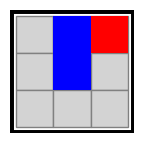

To a state incorporating the following block position(s):


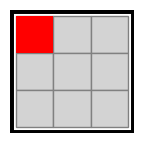

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 3
Goal state is:


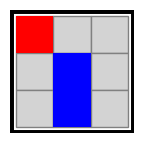

The action path to the solution is:
('blue', 'down')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =      200  (includes start)
Nodes tested (by goal_test)    =       50  (49 expanded + 1 goal)
Nodes left in queue            =      150

Time taken = 0.0314 seconds

Solve the following sliding blocks problem.
Get from this initial state:


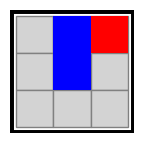

To a state incorporating the following block position(s):


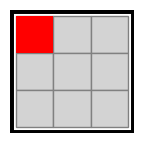

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 3
Goal state is:


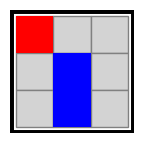

The action path to the solution is:
('blue', 'down')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =       71  (includes start)
Nodes discarded by loop_check  =       45  (26 distinct states added to queue)
Nodes tested (by goal_test)    =       19  (18 expanded + 1 goal)
Nodes left in queue            =        7

Time taken = 0.0285 seconds

Solve the following sliding blocks problem.
Get from this initial state:


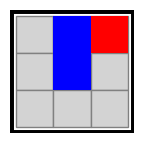

To a state incorporating the following block position(s):


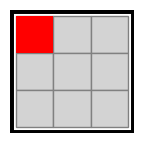

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 4
Goal state is:


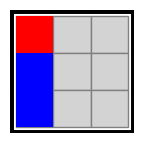

The action path to the solution is:
('blue', 'left')
('red', 'left')
('blue', 'down')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =       16  (includes start)
Nodes discarded by loop_check  =        4  (12 distinct states added to queue)
Nodes tested (by goal_test)    =        5  (4 expanded + 1 goal)
Nodes left in queue            =        7

Time taken = 0.0256 seconds

Solve the following sliding blocks problem.
Get from this initial state:


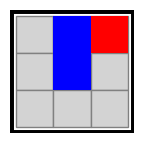

To a state incorporating the following block position(s):


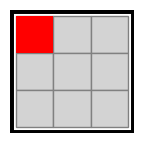

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 3
Goal state is:


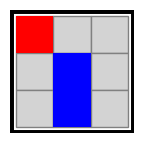

Cost of reaching goal: 3
The action path to the solution is:
('blue', 'down')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =       71  (includes start)
Nodes discarded by loop_check  =       45  (26 distinct states added to queue)
Nodes tested (by goal_test)    =       19  (18 expanded + 1 goal)
Nodes left in queue            =        7

Time taken = 0.0271 seconds

Solve the following sliding blocks problem.
Get from this initial state:


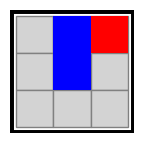

To a state incorporating the following block position(s):


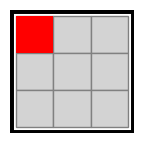

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 3
Goal state is:


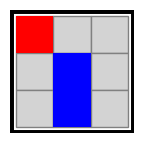

Cost of reaching goal: 3
The action path to the solution is:
('blue', 'down')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =       20  (includes start)
Nodes discarded by loop_check  =        6  (14 distinct states added to queue)
Nodes tested (by goal_test)    =        6  (5 expanded + 1 goal)
Nodes left in queue            =        8

Time taken = 0.0252 seconds

Solve the following sliding blocks problem.
Get from this initial state:


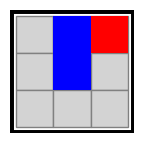

To a state incorporating the following block position(s):


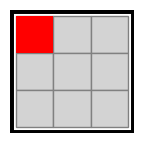

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 3
Goal state is:


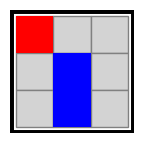

Cost of reaching goal: 3
The action path to the solution is:
('blue', 'down')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =       20  (includes start)
Nodes discarded by loop_check  =        6  (14 distinct states added to queue)
Nodes tested (by goal_test)    =        6  (5 expanded + 1 goal)
Nodes left in queue            =        8

Time taken = 0.0252 seconds

Solve the following sliding blocks problem.
Get from this initial state:


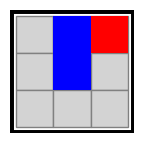

To a state incorporating the following block position(s):


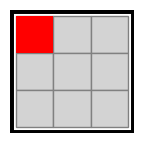

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 4
Goal state is:


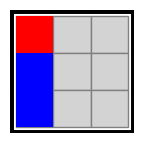

The action path to the solution is:
('blue', 'left')
('red', 'left')
('blue', 'down')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =       16  (includes start)
Nodes discarded by loop_check  =        4  (12 distinct states added to queue)
Nodes tested (by goal_test)    =        5  (4 expanded + 1 goal)
Nodes left in queue            =        7

Time taken = 0.026 seconds

Solve the following sliding blocks problem.
Get from this initial state:


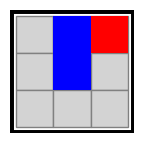

To a state incorporating the following block position(s):


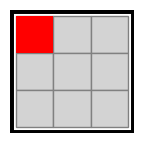

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 3
Goal state is:


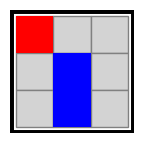

Cost of reaching goal: 3
The action path to the solution is:
('blue', 'down')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =       71  (includes start)
Nodes discarded by loop_check  =       45  (26 distinct states added to queue)
Nodes tested (by goal_test)    =       19  (18 expanded + 1 goal)
Nodes left in queue            =        7

Time taken = 0.0273 seconds

Solve the following sliding blocks problem.
Get from this initial state:


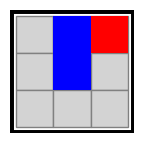

To a state incorporating the following block position(s):


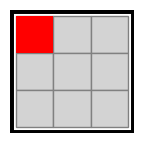

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 3
Goal state is:


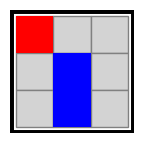

Cost of reaching goal: 3
The action path to the solution is:
('blue', 'down')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =       20  (includes start)
Nodes discarded by loop_check  =        6  (14 distinct states added to queue)
Nodes tested (by goal_test)    =        6  (5 expanded + 1 goal)
Nodes left in queue            =        8

Time taken = 0.0271 seconds

Solve the following sliding blocks problem.
Get from this initial state:


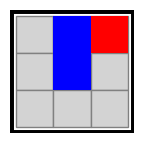

To a state incorporating the following block position(s):


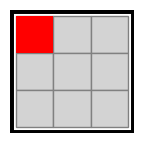

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 3
Goal state is:


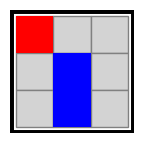

Cost of reaching goal: 3
The action path to the solution is:
('blue', 'down')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =       20  (includes start)
Nodes discarded by loop_check  =        6  (14 distinct states added to queue)
Nodes tested (by goal_test)    =        6  (5 expanded + 1 goal)
Nodes left in queue            =        8

Time taken = 0.0291 seconds



In [57]:
TEST_PUZZLE_0_RESULTS : dict[str,dict] = {}

GOAL_STATE = TEST_PUZZLE_GOAL_0

# BF Tests
TEST_PUZZLE_0_RESULTS["BF"] = search(TEST_PUZZLE_0, 'BF/FIFO', 100000, return_info=True)
TEST_PUZZLE_0_RESULTS["BF_LC"] = search(TEST_PUZZLE_0, 'BF/FIFO', 100000, return_info=True, loop_check=True)
TEST_PUZZLE_0_RESULTS["BF_LC_HEU1"] = search(TEST_PUZZLE_0, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
TEST_PUZZLE_0_RESULTS["BF_LC_COS1"] = search(TEST_PUZZLE_0, 'BF/FIFO', 100000, return_info=True, loop_check=True, cost=COST_1)
TEST_PUZZLE_0_RESULTS["BF_LC_HEU1+COS1"] = search(TEST_PUZZLE_0, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_0_RESULTS["BF_LC_HEU1+COS1_RAND"] = search(TEST_PUZZLE_0, 'BF/FIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_0_RESULTS["BF_LC_HEU2"] = search(TEST_PUZZLE_0, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
TEST_PUZZLE_0_RESULTS["BF_LC_COS2"] = search(TEST_PUZZLE_0, 'BF/FIFO', 100000, return_info=True, loop_check=True, cost=COST_1)
TEST_PUZZLE_0_RESULTS["BF_LC_HEU2+COS1"] = search(TEST_PUZZLE_0, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_0_RESULTS["BF_LC_HEU2+COS1_RAND"] = search(TEST_PUZZLE_0, 'BF/FIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

# DF Tests
TEST_PUZZLE_0_RESULTS["DF"] = search(TEST_PUZZLE_0, 'DF/LIFO', 100000, return_info=True)
TEST_PUZZLE_0_RESULTS["DF_LC"] = search(TEST_PUZZLE_0, 'DF/LIFO', 100000, return_info=True, loop_check=True)
TEST_PUZZLE_0_RESULTS["DF_LC_HEU1"] = search(TEST_PUZZLE_0, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
TEST_PUZZLE_0_RESULTS["DF_LC_COS1"] = search(TEST_PUZZLE_0, 'DF/LIFO', 100000, return_info=True, loop_check=True, cost=COST_1)
TEST_PUZZLE_0_RESULTS["DF_LC_HEU1+COS1"] = search(TEST_PUZZLE_0, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_0_RESULTS["DF_LC_HEU1+COS1_RAND"] = search(TEST_PUZZLE_0, 'DF/LIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_0_RESULTS["DF_LC_HEU2"] = search(TEST_PUZZLE_0, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
TEST_PUZZLE_0_RESULTS["DF_LC_COS2"] = search(TEST_PUZZLE_0, 'DF/LIFO', 100000, return_info=True, loop_check=True, cost=COST_1)
TEST_PUZZLE_0_RESULTS["DF_LC_HEU2+COS1"] = search(TEST_PUZZLE_0, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_0_RESULTS["DF_LC_HEU2+COS1_RAND"] = search(TEST_PUZZLE_0, 'DF/LIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

Solve the following sliding blocks problem.
Get from this initial state:


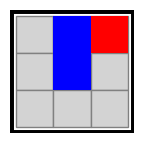

To a state incorporating the following block position(s):


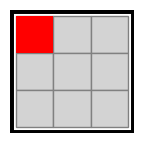

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\lukew\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\lukew\AppData\Local\Temp\ipykernel_26796\842836316.py", line 2, in <module>
    TEST_PUZZLE_0_RESULTS["DF"] = search(TEST_PUZZLE_0, 'DF/LIFO', 100000, return_info=True)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lukew\Downloads\comp2611-cwk01-main\comp2611-cwk01-main\bbmodcache\bbSearch.py", line 419, in search
    suc = problem.successor(state,a)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lukew\AppData\Local\Temp\ipykernel_26796\3633016513.py", line 29, in successor
    return state.next_state(action)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lukew\AppData\Local\Temp\ipykernel_26796\458530644

In [ ]:
print(tableise(TEST_PUZZLE_0_RESULTS))

| Name                 | Term. Cond.         |   Path Length |   Nodes Gen. |   Nodes Tested |   Nodes Discarded | Distinct States                 |   Time Taken |
|----------------------|---------------------|---------------|--------------|----------------|-------------------|---------------------------------|--------------|
| BF                   | GOAL_STATE_FOUND    |             3 |          200 |             50 |                 0 | not recorded (loop_check=False) |    0.0434582 |
| BF_LC                | GOAL_STATE_FOUND    |             3 |           71 |             19 |                45 | 26                              |    0.0422883 |
| BF_LC_HEU1           | GOAL_STATE_FOUND    |             4 |           16 |              5 |                 4 | 12                              |    0.0397968 |
| BF_LC_COS1           | GOAL_STATE_FOUND    |             3 |           71 |             19 |                45 | 26                              |    0.0397352 |
| BF_LC_HEU1+COS

In [ ]:
TEST_PUZZLE_INITIAL_1 = [[2,1,1],
                         [0,3,4],
                         [0,5,6]]

TEST_PUZZLE_GOAL_1 = [[0,0,0],
                      [0,0,0],
                      [1,1,0]]

TEST_PUZZLE_1 = SlidingBlocksPuzzle(TEST_PUZZLE_INITIAL_1, TEST_PUZZLE_GOAL_1)

Solve the following sliding blocks problem.
Get from this initial state:


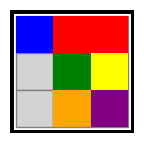

To a state incorporating the following block position(s):


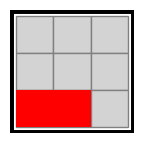

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
......................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   100001  (includes start)
Nodes tested (by goal_test)    =    22287  (all expanded)
Nodes left in queue            =    77713

Time taken = 3.1385 seconds

Solve the following sliding blocks problem.
Get from this initial state:


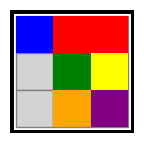

To a state incorporating the following block position(s):


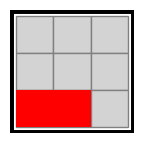

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


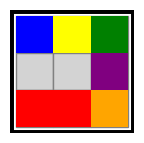

The action path to the solution is:
('blue', 'down')
('red', 'left')
('blue', 'down')
('yellow', 'up')
('green', 'right')
('red', 'down')
('yellow', 'left')
('green', 'up')
('red', 'right')
('blue', 'up')
('blue', 'up')
('red', 'left')
('purple', 'up')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    18459  (includes start)
Nodes discarded by loop_check  =    12738  (5721 distinct states added to queue)
Nodes tested (by goal_test)    =     4698  (4697 expanded + 1 goal)
Nodes left in queue            =     1023

Time taken = 0.4674 seconds

Solve the following sliding blocks problem.
Get from this initial state:


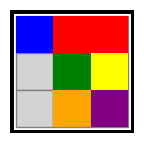

To a state incorporating the following block position(s):


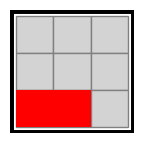

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


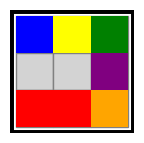

The action path to the solution is:
('blue', 'down')
('red', 'left')
('blue', 'down')
('yellow', 'up')
('green', 'right')
('red', 'down')
('yellow', 'left')
('green', 'up')
('red', 'right')
('blue', 'up')
('blue', 'up')
('red', 'left')
('purple', 'up')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    28068  (includes start)
Nodes discarded by loop_check  =    19164  (8904 distinct states added to queue)
Nodes tested (by goal_test)    =     7874  (7873 expanded + 1 goal)
Nodes left in queue            =     1030

Time taken = 0.8088 seconds

Solve the following sliding blocks problem.
Get from this initial state:


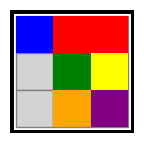

To a state incorporating the following block position(s):


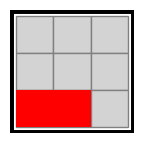

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


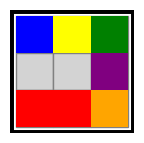

Cost of reaching goal: 15
The action path to the solution is:
('blue', 'down')
('red', 'left')
('blue', 'down')
('yellow', 'up')
('green', 'right')
('red', 'down')
('yellow', 'left')
('green', 'up')
('red', 'right')
('blue', 'up')
('blue', 'up')
('red', 'left')
('purple', 'up')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    18459  (includes start)
Nodes discarded by loop_check  =    12738  (5721 distinct states added to queue)
Nodes tested (by goal_test)    =     4698  (4697 expanded + 1 goal)
Nodes left in queue            =     1023

Time taken = 0.4703 seconds

Solve the following sliding blocks problem.
Get from this initial state:


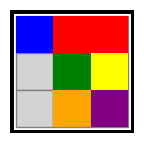

To a state incorporating the following block position(s):


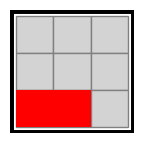

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
......
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


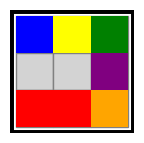

Cost of reaching goal: 15
The action path to the solution is:
('blue', 'down')
('red', 'left')
('blue', 'down')
('yellow', 'up')
('green', 'right')
('red', 'down')
('yellow', 'left')
('green', 'up')
('red', 'right')
('blue', 'up')
('blue', 'up')
('red', 'left')
('purple', 'up')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    23580  (includes start)
Nodes discarded by loop_check  =    16292  (7288 distinct states added to queue)
Nodes tested (by goal_test)    =     6136  (6135 expanded + 1 goal)
Nodes left in queue            =     1152

Time taken = 0.6505 seconds

Solve the following sliding blocks problem.
Get from this initial state:


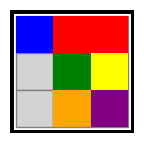

To a state incorporating the following block position(s):


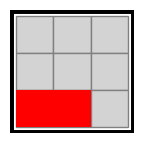

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
......
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


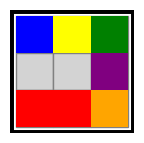

Cost of reaching goal: 15
The action path to the solution is:
('blue', 'down')
('red', 'left')
('blue', 'down')
('yellow', 'up')
('green', 'right')
('red', 'down')
('yellow', 'left')
('green', 'up')
('red', 'right')
('blue', 'up')
('blue', 'up')
('red', 'left')
('purple', 'up')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    23588  (includes start)
Nodes discarded by loop_check  =    16298  (7290 distinct states added to queue)
Nodes tested (by goal_test)    =     6138  (6137 expanded + 1 goal)
Nodes left in queue            =     1152

Time taken = 0.6725 seconds

Solve the following sliding blocks problem.
Get from this initial state:


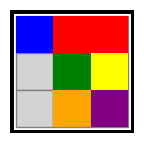

To a state incorporating the following block position(s):


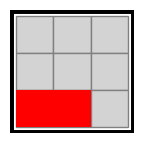

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


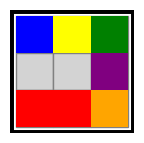

The action path to the solution is:
('blue', 'down')
('red', 'left')
('blue', 'down')
('yellow', 'up')
('green', 'right')
('red', 'down')
('yellow', 'left')
('green', 'up')
('red', 'right')
('blue', 'up')
('blue', 'up')
('red', 'left')
('purple', 'up')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    28068  (includes start)
Nodes discarded by loop_check  =    19164  (8904 distinct states added to queue)
Nodes tested (by goal_test)    =     7874  (7873 expanded + 1 goal)
Nodes left in queue            =     1030

Time taken = 0.8361 seconds

Solve the following sliding blocks problem.
Get from this initial state:


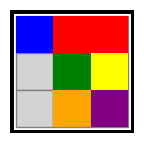

To a state incorporating the following block position(s):


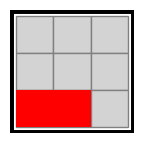

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


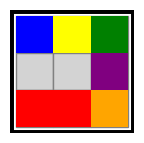

Cost of reaching goal: 15
The action path to the solution is:
('blue', 'down')
('red', 'left')
('blue', 'down')
('yellow', 'up')
('green', 'right')
('red', 'down')
('yellow', 'left')
('green', 'up')
('red', 'right')
('blue', 'up')
('blue', 'up')
('red', 'left')
('purple', 'up')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    18459  (includes start)
Nodes discarded by loop_check  =    12738  (5721 distinct states added to queue)
Nodes tested (by goal_test)    =     4698  (4697 expanded + 1 goal)
Nodes left in queue            =     1023

Time taken = 0.4702 seconds

Solve the following sliding blocks problem.
Get from this initial state:


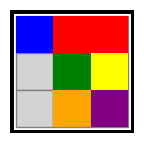

To a state incorporating the following block position(s):


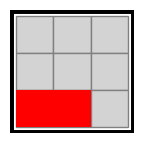

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
......
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


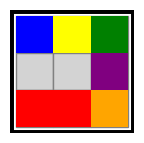

Cost of reaching goal: 15
The action path to the solution is:
('blue', 'down')
('red', 'left')
('blue', 'down')
('yellow', 'up')
('green', 'right')
('red', 'down')
('yellow', 'left')
('green', 'up')
('red', 'right')
('blue', 'up')
('blue', 'up')
('red', 'left')
('purple', 'up')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    23580  (includes start)
Nodes discarded by loop_check  =    16292  (7288 distinct states added to queue)
Nodes tested (by goal_test)    =     6136  (6135 expanded + 1 goal)
Nodes left in queue            =     1152

Time taken = 0.7134 seconds

Solve the following sliding blocks problem.
Get from this initial state:


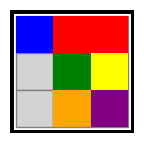

To a state incorporating the following block position(s):


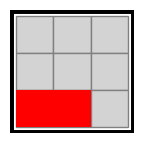

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
......
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


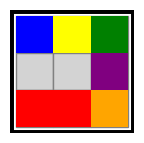

Cost of reaching goal: 15
The action path to the solution is:
('blue', 'down')
('red', 'left')
('yellow', 'up')
('green', 'right')
('blue', 'down')
('red', 'down')
('yellow', 'left')
('green', 'up')
('red', 'right')
('blue', 'up')
('blue', 'up')
('red', 'left')
('purple', 'up')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    23623  (includes start)
Nodes discarded by loop_check  =    16326  (7297 distinct states added to queue)
Nodes tested (by goal_test)    =     6146  (6145 expanded + 1 goal)
Nodes left in queue            =     1151

Time taken = 0.7106 seconds



In [ ]:
GOAL_STATE = TEST_PUZZLE_GOAL_1

TEST_PUZZLE_1_RESULTS : dict[str,dict] = {}

# BF Tests
TEST_PUZZLE_1_RESULTS["TC1_BF"] = search(TEST_PUZZLE_1, 'BF/FIFO', 100000, return_info=True)
TEST_PUZZLE_1_RESULTS["TC1_BF_LC"] = search(TEST_PUZZLE_1, 'BF/FIFO', 100000, return_info=True, loop_check=True)

TEST_PUZZLE_1_RESULTS["TC1_BF_LC_HEU1"] = search(TEST_PUZZLE_1, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
TEST_PUZZLE_1_RESULTS["TC1_BF_LC_COS1"] = search(TEST_PUZZLE_1, 'BF/FIFO', 100000, return_info=True, loop_check=True, cost=COST_1)
TEST_PUZZLE_1_RESULTS["TC1_BF_LC_HEU1+COS1"] = search(TEST_PUZZLE_1, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_1_RESULTS["TC1_BF_LC_HEU1+COS1_RAND"] = search(TEST_PUZZLE_1, 'BF/FIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

TEST_PUZZLE_1_RESULTS["TC1_BF_LC_HEU2"] = search(TEST_PUZZLE_1, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
TEST_PUZZLE_1_RESULTS["TC1_BF_LC_COS2"] = search(TEST_PUZZLE_1, 'BF/FIFO', 100000, return_info=True, loop_check=True, cost=COST_1)
TEST_PUZZLE_1_RESULTS["TC1_BF_LC_HEU2+COS1"] = search(TEST_PUZZLE_1, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_1_RESULTS["TC1_BF_LC_HEU2+COS1_RAND"] = search(TEST_PUZZLE_1, 'BF/FIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

# DF Tests
TEST_PUZZLE_1_RESULTS["TC_1DF"] = search(TEST_PUZZLE_1, 'DF/LIFO', 100000, return_info=True)
TEST_PUZZLE_1_RESULTS["TC_1DF_LC"] = search(TEST_PUZZLE_1, 'DF/LIFO', 100000, return_info=True, loop_check=True)
TEST_PUZZLE_1_RESULTS["TC_1DF_LC_HEU1"] = search(TEST_PUZZLE_1, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_1)
TEST_PUZZLE_1_RESULTS["TC_1DF_LC_COS1"] = search(TEST_PUZZLE_1, 'DF/LIFO', 100000, return_info=True, loop_check=True, cost=COST_1)
TEST_PUZZLE_1_RESULTS["TC_1DF_LC_HEU1+COS1"] = search(TEST_PUZZLE_1, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_1, cost=COST_1)   
TEST_PUZZLE_1_RESULTS["TC_1DF_LC_HEU1+COS1_RAND"] = search(TEST_PUZZLE_1, 'DF/LIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_1, cost=COST_1)

TEST_PUZZLE_1_RESULTS["TC1_DF_LC_HEU2"] = search(TEST_PUZZLE_1, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
TEST_PUZZLE_1_RESULTS["TC1_DF_LC_COS2"] = search(TEST_PUZZLE_1, 'DF/LIFO', 100000, return_info=True, loop_check=True, cost=COST_1)
TEST_PUZZLE_1_RESULTS["TC1_DF_LC_HEU2+COS1"] = search(TEST_PUZZLE_1, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)   
TEST_PUZZLE_1_RESULTS["TC1_DF_LC_HEU2+COS1_RAND"] = search(TEST_PUZZLE_1, 'DF/LIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

Solve the following sliding blocks problem.
Get from this initial state:


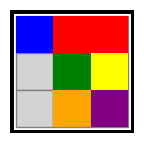

To a state incorporating the following block position(s):


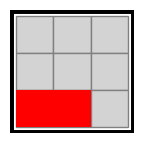

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
..................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   100001  (includes start)
Nodes tested (by goal_test)    =    18184  (all expanded)
Nodes left in queue            =    81816

Time taken = 85.1267 seconds

Solve the following sliding blocks problem.
Get from this initial state:


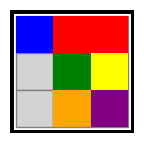

To a state incorporating the following block position(s):


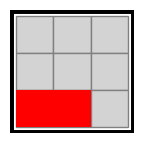

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 649
Goal state is:


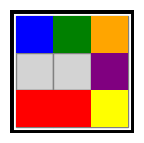

The action path to the solution is:
('orange', 'left')
('purple', 'left')
('orange', 'up')
('purple', 'left')
('yellow', 'down')
('yellow', 'left')
('green', 'right')
('orange', 'right')
('purple', 'up')
('yellow', 'right')
('orange', 'down')
('purple', 'down')
('green', 'left')
('yellow', 'up')
('purple', 'up')
('orange', 'right')
('green', 'down')
('purple', 'down')
('yellow', 'left')
('orange', 'up')
('purple', 'up')
('green', 'right')
('yellow', 'down')
('purple', 'down')
('blue', 'down')
('orange', 'left')
('red', 'left')
('green', 'up')
('yellow', 'right')
('purple', 'right')
('green', 'up')
('orange', 'right')
('purple', 'up')
('yellow', 'left')
('orange', 'down')
('purple', 'right')
('yellow', 'up')
('orange', 'left')
('purple', 'down')
('orange', 'left')
('purple', 'left')
('yellow', 'right')
('purple', 'up')
('orange', 'right')
('orange', 'right')
('purple', 'down')
('purple', 'left')
('orange', 'left')
('yellow', 'down')
('blue', 'right')
('purple', 'up')
('orange', 'left')


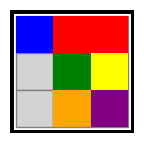

To a state incorporating the following block position(s):


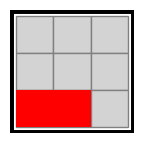

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=HEURISTIC_1
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 649
Goal state is:


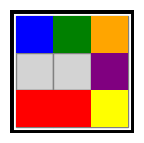

The action path to the solution is:
('orange', 'left')
('purple', 'left')
('orange', 'up')
('purple', 'left')
('yellow', 'down')
('yellow', 'left')
('green', 'right')
('orange', 'right')
('purple', 'up')
('yellow', 'right')
('orange', 'down')
('purple', 'down')
('green', 'left')
('yellow', 'up')
('purple', 'up')
('orange', 'right')
('green', 'down')
('purple', 'down')
('yellow', 'left')
('orange', 'up')
('purple', 'up')
('green', 'right')
('yellow', 'down')
('purple', 'down')
('blue', 'down')
('orange', 'left')
('red', 'left')
('green', 'up')
('yellow', 'right')
('purple', 'right')
('green', 'up')
('orange', 'right')
('purple', 'up')
('yellow', 'left')
('orange', 'down')
('purple', 'right')
('yellow', 'up')
('orange', 'left')
('purple', 'down')
('orange', 'left')
('purple', 'left')
('yellow', 'right')
('purple', 'up')
('orange', 'right')
('orange', 'right')
('purple', 'down')
('purple', 'left')
('orange', 'left')
('yellow', 'down')
('blue', 'right')
('purple', 'up')
('orange', 'left')


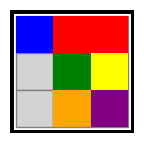

To a state incorporating the following block position(s):


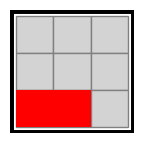

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


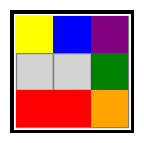

Cost of reaching goal: 15
The action path to the solution is:
('orange', 'left')
('green', 'down')
('yellow', 'left')
('yellow', 'left')
('red', 'down')
('blue', 'right')
('yellow', 'up')
('red', 'left')
('purple', 'up')
('purple', 'up')
('green', 'right')
('green', 'up')
('orange', 'right')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    18092  (includes start)
Nodes discarded by loop_check  =    12463  (5629 distinct states added to queue)
Nodes tested (by goal_test)    =     4599  (4598 expanded + 1 goal)
Nodes left in queue            =     1030

Time taken = 0.4726 seconds

Solve the following sliding blocks problem.
Get from this initial state:


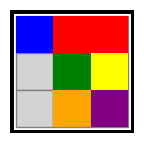

To a state incorporating the following block position(s):


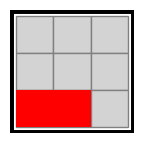

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=HEURISTIC_1
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


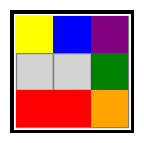

Cost of reaching goal: 15
The action path to the solution is:
('orange', 'left')
('green', 'down')
('yellow', 'left')
('yellow', 'left')
('red', 'down')
('blue', 'right')
('yellow', 'up')
('red', 'left')
('purple', 'up')
('purple', 'up')
('green', 'right')
('green', 'up')
('orange', 'right')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    18092  (includes start)
Nodes discarded by loop_check  =    12463  (5629 distinct states added to queue)
Nodes tested (by goal_test)    =     4599  (4598 expanded + 1 goal)
Nodes left in queue            =     1030

Time taken = 0.4861 seconds

Solve the following sliding blocks problem.
Get from this initial state:


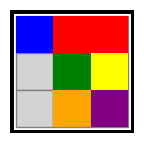

To a state incorporating the following block position(s):


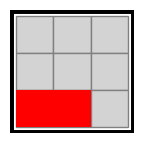

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=HEURISTIC_1
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


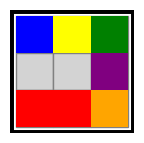

Cost of reaching goal: 15
The action path to the solution is:
('blue', 'down')
('red', 'left')
('yellow', 'up')
('green', 'right')
('blue', 'down')
('red', 'down')
('yellow', 'left')
('green', 'up')
('red', 'right')
('blue', 'up')
('blue', 'up')
('red', 'left')
('purple', 'up')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    18359  (includes start)
Nodes discarded by loop_check  =    12633  (5726 distinct states added to queue)
Nodes tested (by goal_test)    =     4675  (4674 expanded + 1 goal)
Nodes left in queue            =     1051

Time taken = 0.5064 seconds

Solve the following sliding blocks problem.
Get from this initial state:


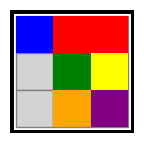

To a state incorporating the following block position(s):


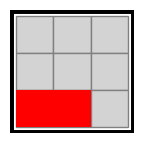

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
........
:-)) *SUCCESS* ((-:

Path length = 113
Goal state is:


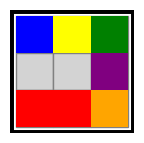

The action path to the solution is:
('orange', 'left')
('purple', 'left')
('orange', 'up')
('purple', 'left')
('yellow', 'down')
('yellow', 'left')
('green', 'right')
('orange', 'right')
('purple', 'up')
('yellow', 'right')
('orange', 'down')
('purple', 'down')
('green', 'left')
('yellow', 'up')
('purple', 'up')
('orange', 'right')
('green', 'down')
('purple', 'down')
('yellow', 'left')
('orange', 'up')
('purple', 'up')
('green', 'right')
('yellow', 'down')
('purple', 'down')
('blue', 'down')
('red', 'left')
('orange', 'up')
('yellow', 'up')
('purple', 'right')
('orange', 'down')
('blue', 'down')
('yellow', 'left')
('purple', 'up')
('orange', 'up')
('purple', 'right')
('yellow', 'right')
('yellow', 'down')
('purple', 'left')
('purple', 'left')
('orange', 'down')
('orange', 'left')
('green', 'up')
('yellow', 'right')
('orange', 'down')
('purple', 'right')
('green', 'up')
('purple', 'right')
('orange', 'up')
('orange', 'left')
('purple', 'left')
('purple', 'down')
('orange', 'right')
('o

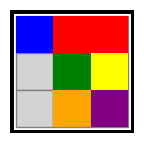

To a state incorporating the following block position(s):


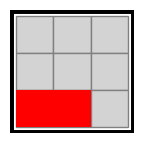

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


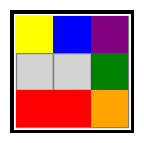

Cost of reaching goal: 15
The action path to the solution is:
('orange', 'left')
('green', 'down')
('yellow', 'left')
('yellow', 'left')
('red', 'down')
('blue', 'right')
('yellow', 'up')
('red', 'left')
('purple', 'up')
('purple', 'up')
('green', 'right')
('green', 'up')
('orange', 'right')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    18092  (includes start)
Nodes discarded by loop_check  =    12463  (5629 distinct states added to queue)
Nodes tested (by goal_test)    =     4599  (4598 expanded + 1 goal)
Nodes left in queue            =     1030

Time taken = 0.4729 seconds

Solve the following sliding blocks problem.
Get from this initial state:


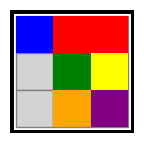

To a state incorporating the following block position(s):


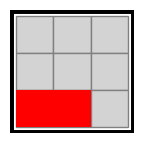

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
......
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


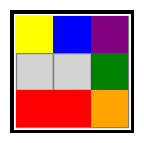

Cost of reaching goal: 15
The action path to the solution is:
('orange', 'left')
('green', 'down')
('yellow', 'left')
('yellow', 'left')
('red', 'down')
('blue', 'right')
('yellow', 'up')
('red', 'left')
('purple', 'up')
('purple', 'up')
('green', 'right')
('green', 'up')
('orange', 'right')
('orange', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    24276  (includes start)
Nodes discarded by loop_check  =    16581  (7695 distinct states added to queue)
Nodes tested (by goal_test)    =     6347  (6346 expanded + 1 goal)
Nodes left in queue            =     1348

Time taken = 0.6827 seconds

Solve the following sliding blocks problem.
Get from this initial state:


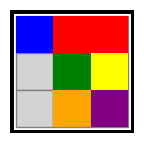

To a state incorporating the following block position(s):


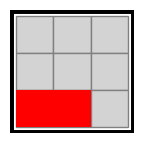

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
......
:-)) *SUCCESS* ((-:

Path length = 15
Goal state is:


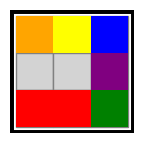

Cost of reaching goal: 15
The action path to the solution is:
('orange', 'left')
('green', 'down')
('yellow', 'left')
('yellow', 'left')
('red', 'down')
('blue', 'right')
('blue', 'right')
('yellow', 'up')
('yellow', 'right')
('orange', 'up')
('orange', 'up')
('red', 'left')
('purple', 'up')
('green', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    24278  (includes start)
Nodes discarded by loop_check  =    16583  (7695 distinct states added to queue)
Nodes tested (by goal_test)    =     6348  (6347 expanded + 1 goal)
Nodes left in queue            =     1347

Time taken = 0.6952 seconds



In [ ]:
print(tableise(TEST_PUZZLE_1_RESULTS))

| Name                     | Term. Cond.         |   Path Length |   Nodes Gen. |   Nodes Tested |   Nodes Discarded | Distinct States                 |   Time Taken |
|--------------------------|---------------------|---------------|--------------|----------------|-------------------|---------------------------------|--------------|
| TC1_BF                   | NODE_LIMIT_EXCEEDED |               |       100001 |          22287 |                 0 | not recorded (loop_check=False) |     3.13848  |
| TC1_BF_LC                | GOAL_STATE_FOUND    |            15 |        18459 |           4698 |             12738 | 5721                            |     0.46745  |
| TC1_BF_LC_HEU1           | GOAL_STATE_FOUND    |            15 |        28068 |           7874 |             19164 | 8904                            |     0.80878  |
| TC1_BF_LC_COS1           | GOAL_STATE_FOUND    |            15 |        18459 |           4698 |             12738 | 5721                            |     0.4

Solve the following sliding blocks problem.
Get from this initial state:


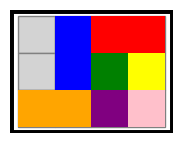

To a state incorporating the following block position(s):


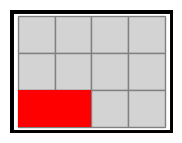

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=HEURISTIC_1
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


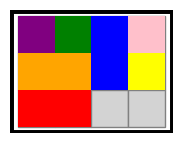

The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('yellow', 'up')
('purple', 'up')
('orange', 'right')
('pink', 'up')
('orange', 'right')
('green', 'down')
('green', 'left')
('purple', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('green', 'up')
('purple', 'left')
('orange', 'left')
('purple', 'up')
('orange', 'left')
('red', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'right')
('green', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    54693  (includes start)
Nodes discarded by loop_check  =    38449  (16244 distinct states added to queue)
Nodes tested (by goal_test)    =    16010  (16009 expanded + 1 goal)
Nodes left in queue            =      234

Time taken = 1.8832 seconds



In [ ]:
TEST_PUZZLE_INITIAL_2 = [[0,2,1,1],
                         [0,2,3,4],
                         [5,5,6,7]]

TEST_PUZZLE_GOAL_2 = [[0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [1, 1, 0, 0]]

TEST_PUZZLE_2 = SlidingBlocksPuzzle(TEST_PUZZLE_INITIAL_2, TEST_PUZZLE_GOAL_2)

Solve the following sliding blocks problem.
Get from this initial state:


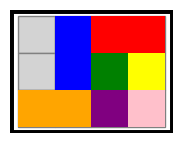

To a state incorporating the following block position(s):


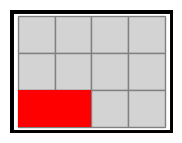

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   100001  (includes start)
Nodes tested (by goal_test)    =    23773  (all expanded)
Nodes left in queue            =    76227

Time taken = 3.4479 seconds

Solve the following sliding blocks problem.
Get from this initial state:


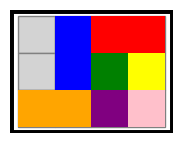

To a state incorporating the following block position(s):


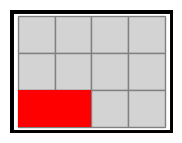

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


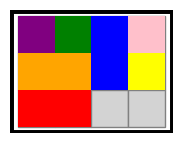

The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('yellow', 'up')
('purple', 'up')
('orange', 'right')
('pink', 'up')
('orange', 'right')
('green', 'down')
('green', 'left')
('purple', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('green', 'up')
('purple', 'left')
('orange', 'left')
('purple', 'up')
('orange', 'left')
('red', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'right')
('green', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    55359  (includes start)
Nodes discarded by loop_check  =    38894  (16465 distinct states added to queue)
Nodes tested (by goal_test)    =    16243  (16242 expanded + 1 goal)
Nodes left in queue            =      222

Time taken = 1.6908 seconds

Solve the following sliding blocks problem.
Get from this initial state:


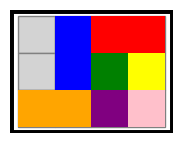

To a state incorporating the following block position(s):


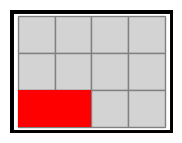

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....................
:-)) *SUCCESS* ((-:

Path length = 51
Goal state is:


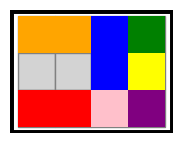

The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('purple', 'up')
('orange', 'right')
('blue', 'down')
('red', 'left')
('yellow', 'up')
('purple', 'right')
('green', 'right')
('green', 'up')
('orange', 'up')
('pink', 'left')
('purple', 'down')
('yellow', 'down')
('green', 'right')
('pink', 'left')
('purple', 'left')
('yellow', 'down')
('green', 'down')
('red', 'right')
('blue', 'up')
('pink', 'left')
('purple', 'left')
('yellow', 'left')
('green', 'down')
('orange', 'right')
('red', 'right')
('blue', 'right')
('pink', 'up')
('purple', 'left')
('blue', 'down')
('red', 'left')
('red', 'left')
('orange', 'up')
('green', 'up')
('yellow', 'right')
('blue', 'right')
('purple', 'right')
('pink', 'down')
('red', 'down')
('orange', 'left')
('green', 'up')
('yellow', 'up')
('orange', 'left')
('blue', 'up')
('purple', 'right')
('purple', 'right')
('pink', 'right')
('pink', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    6869

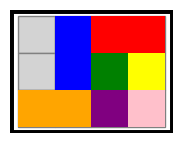

To a state incorporating the following block position(s):


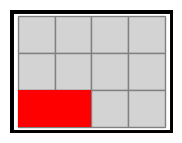

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


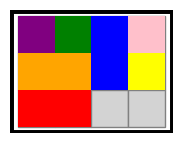

Cost of reaching goal: 32
The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('yellow', 'up')
('purple', 'up')
('orange', 'right')
('pink', 'up')
('orange', 'right')
('green', 'down')
('green', 'left')
('purple', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('green', 'up')
('purple', 'left')
('orange', 'left')
('purple', 'up')
('orange', 'left')
('red', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'right')
('green', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    55359  (includes start)
Nodes discarded by loop_check  =    38894  (16465 distinct states added to queue)
Nodes tested (by goal_test)    =    16243  (16242 expanded + 1 goal)
Nodes left in queue            =      222

Time taken = 1.7669 seconds

Solve the following sliding blocks problem.
Get from this initial stat

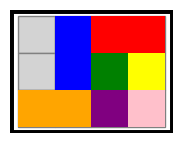

To a state incorporating the following block position(s):


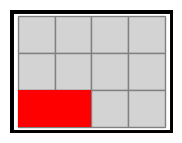

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


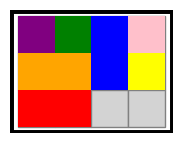

Cost of reaching goal: 32
The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('yellow', 'up')
('purple', 'up')
('orange', 'right')
('pink', 'up')
('orange', 'right')
('green', 'down')
('green', 'left')
('purple', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('green', 'up')
('purple', 'left')
('orange', 'left')
('purple', 'up')
('orange', 'left')
('red', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'right')
('green', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    55822  (includes start)
Nodes discarded by loop_check  =    39157  (16665 distinct states added to queue)
Nodes tested (by goal_test)    =    16387  (16386 expanded + 1 goal)
Nodes left in queue            =      278

Time taken = 1.8543 seconds

Solve the following sliding blocks problem.
Get from this initial stat

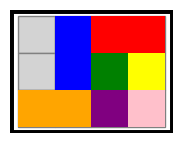

To a state incorporating the following block position(s):


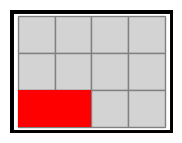

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


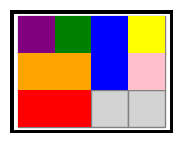

Cost of reaching goal: 32
The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('purple', 'up')
('yellow', 'up')
('orange', 'right')
('pink', 'up')
('orange', 'right')
('green', 'down')
('purple', 'left')
('green', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('green', 'up')
('purple', 'left')
('purple', 'up')
('orange', 'left')
('orange', 'left')
('red', 'down')
('pink', 'down')
('yellow', 'right')
('blue', 'right')
('green', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    55822  (includes start)
Nodes discarded by loop_check  =    39157  (16665 distinct states added to queue)
Nodes tested (by goal_test)    =    16387  (16386 expanded + 1 goal)
Nodes left in queue            =      278

Time taken = 2.3178 seconds

Solve the following sliding blocks problem.
Get from this initial state:

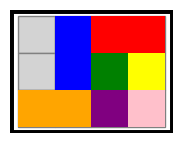

To a state incorporating the following block position(s):


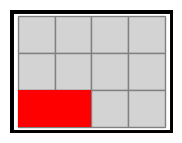

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
....................
:-)) *SUCCESS* ((-:

Path length = 51
Goal state is:


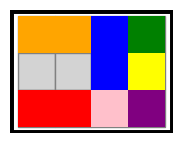

The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('purple', 'up')
('orange', 'right')
('blue', 'down')
('red', 'left')
('yellow', 'up')
('purple', 'right')
('green', 'right')
('green', 'up')
('orange', 'up')
('pink', 'left')
('purple', 'down')
('yellow', 'down')
('green', 'right')
('pink', 'left')
('purple', 'left')
('yellow', 'down')
('green', 'down')
('red', 'right')
('blue', 'up')
('pink', 'left')
('purple', 'left')
('yellow', 'left')
('green', 'down')
('orange', 'right')
('red', 'right')
('blue', 'right')
('pink', 'up')
('purple', 'left')
('blue', 'down')
('red', 'left')
('red', 'left')
('orange', 'up')
('green', 'up')
('yellow', 'right')
('blue', 'right')
('purple', 'right')
('pink', 'down')
('red', 'down')
('orange', 'left')
('green', 'up')
('yellow', 'up')
('orange', 'left')
('blue', 'up')
('purple', 'right')
('purple', 'right')
('pink', 'right')
('pink', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =    6869

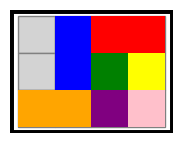

To a state incorporating the following block position(s):


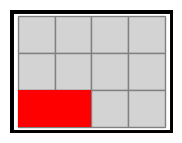

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


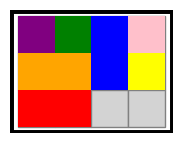

Cost of reaching goal: 32
The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('yellow', 'up')
('purple', 'up')
('orange', 'right')
('pink', 'up')
('orange', 'right')
('green', 'down')
('green', 'left')
('purple', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('green', 'up')
('purple', 'left')
('orange', 'left')
('purple', 'up')
('orange', 'left')
('red', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'right')
('green', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    55822  (includes start)
Nodes discarded by loop_check  =    39157  (16665 distinct states added to queue)
Nodes tested (by goal_test)    =    16387  (16386 expanded + 1 goal)
Nodes left in queue            =      278

Time taken = 1.8523 seconds

Solve the following sliding blocks problem.
Get from this initial stat

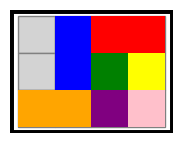

To a state incorporating the following block position(s):


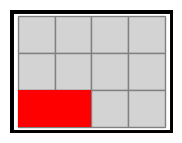

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


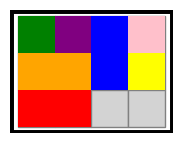

Cost of reaching goal: 32
The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('yellow', 'up')
('purple', 'up')
('pink', 'up')
('orange', 'right')
('orange', 'right')
('green', 'down')
('purple', 'left')
('green', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('purple', 'left')
('orange', 'left')
('green', 'up')
('purple', 'up')
('orange', 'left')
('red', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'right')
('purple', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    55825  (includes start)
Nodes discarded by loop_check  =    39158  (16667 distinct states added to queue)
Nodes tested (by goal_test)    =    16388  (16387 expanded + 1 goal)
Nodes left in queue            =      279

Time taken = 1.8824 seconds



In [ ]:

GOAL_STATE = TEST_PUZZLE_GOAL_2

TEST_PUZZLE_2_RESULTS : dict[str,dict] = {}

# BF Tests
TEST_PUZZLE_2_RESULTS["BF"] = search(TEST_PUZZLE_2, 'BF/FIFO', 100000, return_info=True)
TEST_PUZZLE_2_RESULTS["BF_LC"] = search(TEST_PUZZLE_2, 'BF/FIFO', 100000, return_info=True, loop_check=True)

TEST_PUZZLE_2_RESULTS["BF_LC_HEU1"] = search(TEST_PUZZLE_2, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
TEST_PUZZLE_2_RESULTS["BF_LC_COS1"] = search(TEST_PUZZLE_2, 'BF/FIFO', 100000, return_info=True, loop_check=True, cost=COST_1)
TEST_PUZZLE_2_RESULTS["BF_LC_HEU1+COS1"] = search(TEST_PUZZLE_2, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_2_RESULTS["BF_LC_HEU1+COS1_RAND"] = search(TEST_PUZZLE_2, 'BF/FIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

TEST_PUZZLE_2_RESULTS["BF_LC_HEU2"] = search(TEST_PUZZLE_2, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
TEST_PUZZLE_2_RESULTS["BF_LC_HEU2+COS1"] = search(TEST_PUZZLE_2, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_2_RESULTS["BF_LC_HEU2+COS1_RAND"] = search(TEST_PUZZLE_2, 'BF/FIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

# DF Tests
TEST_PUZZLE_2_RESULTS["DF_LC"] = search(TEST_PUZZLE_2, 'DF/LIFO', 100000, return_info=True, loop_check=True)

TEST_PUZZLE_2_RESULTS["DF_LC_HEU1"] = search(TEST_PUZZLE_2, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
TEST_PUZZLE_2_RESULTS["DF_LC_COS1"] = search(TEST_PUZZLE_2, 'DF/LIFO', 100000, return_info=True, loop_check=True, cost=COST_1)
TEST_PUZZLE_2_RESULTS["DF_LC_HEU1+COS1"] = search(TEST_PUZZLE_2, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_2_RESULTS["DF_LC_HEU1+COS1_RAND"] = search(TEST_PUZZLE_2, 'DF/LIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

TEST_PUZZLE_2_RESULTS["DF_LC_HEU2"] = search(TEST_PUZZLE_2, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
TEST_PUZZLE_2_RESULTS["DF_LC_HEU2+COS1"] = search(TEST_PUZZLE_2, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)
TEST_PUZZLE_2_RESULTS["DF_LC_HEU2+COS1_RAND"] = search(TEST_PUZZLE_2, 'DF/LIFO', 100000, return_info=True, randomise=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

Solve the following sliding blocks problem.
Get from this initial state:


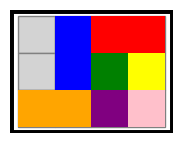

To a state incorporating the following block position(s):


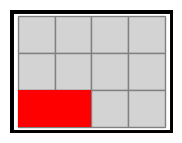

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...
:-)) *SUCCESS* ((-:

Path length = 2598
Goal state is:


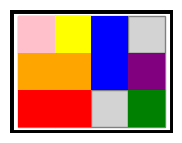

The action path to the solution is:
('blue', 'left')
('green', 'left')
('purple', 'up')
('pink', 'left')
('yellow', 'down')
('purple', 'right')
('pink', 'up')
('orange', 'right')
('green', 'up')
('pink', 'left')
('purple', 'left')
('orange', 'left')
('purple', 'down')
('pink', 'right')
('pink', 'right')
('purple', 'up')
('purple', 'left')
('pink', 'left')
('pink', 'down')
('yellow', 'up')
('pink', 'right')
('orange', 'right')
('purple', 'right')
('blue', 'down')
('green', 'down')
('red', 'left')
('yellow', 'up')
('pink', 'up')
('orange', 'right')
('green', 'down')
('purple', 'left')
('pink', 'left')
('yellow', 'down')
('blue', 'up')
('green', 'left')
('purple', 'down')
('pink', 'left')
('yellow', 'up')
('orange', 'up')
('purple', 'right')
('pink', 'down')
('purple', 'right')
('pink', 'right')
('orange', 'left')
('purple', 'up')
('pink', 'right')
('orange', 'down')
('purple', 'left')
('pink', 'up')
('purple', 'left')
('orange', 'right')
('purple', 'down')
('red', 'down')
('yellow', 'lef

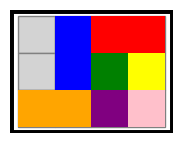

To a state incorporating the following block position(s):


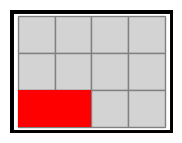

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 111
Goal state is:


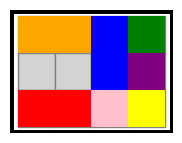

The action path to the solution is:
('blue', 'left')
('red', 'left')
('yellow', 'up')
('pink', 'up')
('purple', 'right')
('orange', 'right')
('green', 'left')
('pink', 'left')
('purple', 'up')
('orange', 'right')
('green', 'down')
('pink', 'left')
('purple', 'left')
('yellow', 'down')
('green', 'left')
('pink', 'down')
('purple', 'left')
('yellow', 'up')
('orange', 'up')
('pink', 'right')
('pink', 'right')
('purple', 'down')
('purple', 'right')
('orange', 'left')
('pink', 'up')
('purple', 'right')
('orange', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('purple', 'up')
('orange', 'right')
('yellow', 'left')
('pink', 'left')
('purple', 'up')
('green', 'right')
('blue', 'down')
('yellow', 'left')
('red', 'right')
('green', 'up')
('orange', 'left')
('green', 'up')
('red', 'left')
('purple', 'down')
('purple', 'down')
('red', 'right')
('green', 'down')
('pink', 'left')
('red', 'up')
('purple', 'up')
('orange', 'right')
('green', 'right')
('blue', 'right')
('yellow', 'down')
('

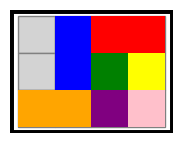

To a state incorporating the following block position(s):


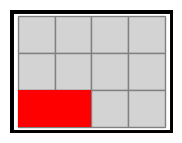

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


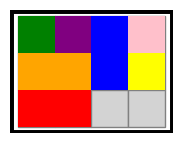

Cost of reaching goal: 32
The action path to the solution is:
('blue', 'left')
('green', 'left')
('purple', 'up')
('red', 'left')
('yellow', 'up')
('orange', 'right')
('pink', 'up')
('orange', 'right')
('green', 'down')
('purple', 'left')
('green', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('purple', 'left')
('green', 'up')
('purple', 'up')
('orange', 'left')
('orange', 'left')
('red', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'right')
('purple', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    55628  (includes start)
Nodes discarded by loop_check  =    39060  (16568 distinct states added to queue)
Nodes tested (by goal_test)    =    16332  (16331 expanded + 1 goal)
Nodes left in queue            =      236

Time taken = 1.7537 seconds

Solve the following sliding blocks problem.
Get from this initial sta

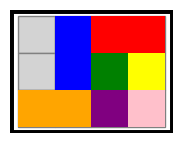

To a state incorporating the following block position(s):


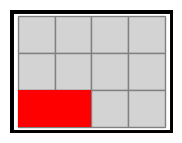

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


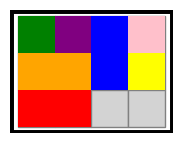

Cost of reaching goal: 32
The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('purple', 'up')
('orange', 'right')
('yellow', 'up')
('pink', 'up')
('orange', 'right')
('green', 'down')
('purple', 'left')
('green', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('purple', 'left')
('green', 'up')
('purple', 'up')
('orange', 'left')
('orange', 'left')
('red', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'right')
('purple', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    55418  (includes start)
Nodes discarded by loop_check  =    38864  (16554 distinct states added to queue)
Nodes tested (by goal_test)    =    16257  (16256 expanded + 1 goal)
Nodes left in queue            =      297

Time taken = 1.8379 seconds

Solve the following sliding blocks problem.
Get from this initial sta

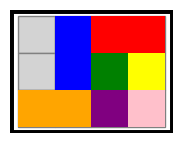

To a state incorporating the following block position(s):


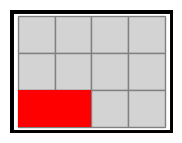

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


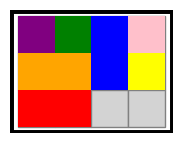

Cost of reaching goal: 32
The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('yellow', 'up')
('purple', 'up')
('pink', 'up')
('orange', 'right')
('orange', 'right')
('green', 'down')
('green', 'left')
('purple', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('purple', 'left')
('green', 'up')
('orange', 'left')
('purple', 'up')
('orange', 'left')
('red', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'right')
('green', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    55454  (includes start)
Nodes discarded by loop_check  =    38884  (16570 distinct states added to queue)
Nodes tested (by goal_test)    =    16270  (16269 expanded + 1 goal)
Nodes left in queue            =      300

Time taken = 1.8908 seconds

Solve the following sliding blocks problem.
Get from this initial stat

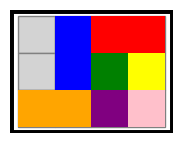

To a state incorporating the following block position(s):


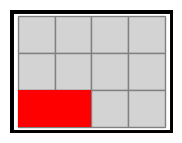

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 111
Goal state is:


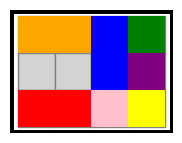

The action path to the solution is:
('blue', 'left')
('red', 'left')
('yellow', 'up')
('pink', 'up')
('purple', 'right')
('orange', 'right')
('green', 'left')
('pink', 'left')
('purple', 'up')
('orange', 'right')
('green', 'down')
('pink', 'left')
('purple', 'left')
('yellow', 'down')
('green', 'left')
('pink', 'down')
('purple', 'left')
('yellow', 'up')
('orange', 'up')
('pink', 'right')
('pink', 'right')
('purple', 'down')
('purple', 'right')
('orange', 'left')
('pink', 'up')
('purple', 'right')
('orange', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('purple', 'up')
('orange', 'right')
('yellow', 'left')
('pink', 'left')
('purple', 'up')
('green', 'right')
('blue', 'down')
('yellow', 'left')
('red', 'right')
('green', 'up')
('orange', 'left')
('green', 'up')
('red', 'left')
('purple', 'down')
('purple', 'down')
('red', 'right')
('green', 'down')
('pink', 'left')
('red', 'up')
('purple', 'up')
('orange', 'right')
('green', 'right')
('blue', 'right')
('yellow', 'down')
('

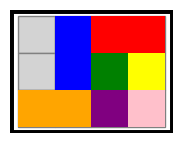

To a state incorporating the following block position(s):


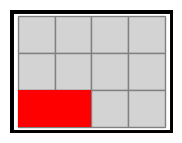

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


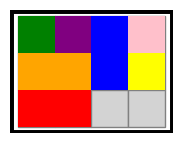

Cost of reaching goal: 32
The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('purple', 'up')
('orange', 'right')
('yellow', 'up')
('pink', 'up')
('orange', 'right')
('green', 'down')
('purple', 'left')
('green', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('purple', 'left')
('green', 'up')
('purple', 'up')
('orange', 'left')
('orange', 'left')
('red', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'right')
('purple', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    55418  (includes start)
Nodes discarded by loop_check  =    38864  (16554 distinct states added to queue)
Nodes tested (by goal_test)    =    16257  (16256 expanded + 1 goal)
Nodes left in queue            =      297

Time taken = 1.9634 seconds

Solve the following sliding blocks problem.
Get from this initial sta

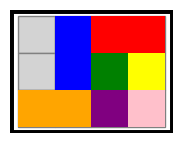

To a state incorporating the following block position(s):


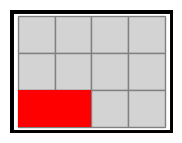

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 32
Goal state is:


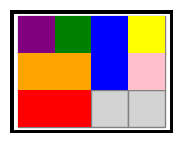

Cost of reaching goal: 32
The action path to the solution is:
('blue', 'left')
('red', 'left')
('green', 'left')
('purple', 'up')
('yellow', 'up')
('pink', 'up')
('orange', 'right')
('orange', 'right')
('green', 'down')
('green', 'left')
('purple', 'left')
('purple', 'down')
('red', 'down')
('yellow', 'left')
('pink', 'up')
('red', 'right')
('blue', 'right')
('green', 'up')
('purple', 'left')
('green', 'up')
('purple', 'up')
('orange', 'left')
('orange', 'left')
('red', 'down')
('pink', 'down')
('yellow', 'right')
('blue', 'right')
('green', 'right')
('purple', 'up')
('orange', 'up')
('red', 'left')
('red', 'left')


SEARCH SPACE STATS:
Total nodes generated          =    55425  (includes start)
Nodes discarded by loop_check  =    38870  (16555 distinct states added to queue)
Nodes tested (by goal_test)    =    16261  (16260 expanded + 1 goal)
Nodes left in queue            =      294

Time taken = 1.9741 seconds



In [ ]:
print(tableise(TEST_PUZZLE_2_RESULTS))

| Name                 | Term. Cond.         |   Path Length |   Nodes Gen. |   Nodes Tested |   Nodes Discarded | Distinct States                 |   Time Taken |
|----------------------|---------------------|---------------|--------------|----------------|-------------------|---------------------------------|--------------|
| BF                   | NODE_LIMIT_EXCEEDED |               |       100001 |          23773 |                 0 | not recorded (loop_check=False) |     3.44794  |
| BF_LC                | GOAL_STATE_FOUND    |            32 |        55359 |          16243 |             38894 | 16465                           |     1.69077  |
| BF_LC_HEU1           | GOAL_STATE_FOUND    |            51 |        68693 |          20249 |             47740 | 20953                           |     2.35538  |
| BF_LC_COS1           | GOAL_STATE_FOUND    |            32 |        55359 |          16243 |             38894 | 16465                           |     1.76687  |
| BF_LC_HEU1+COS

In [67]:
EIGHT_PUZZLE_I = [[1, 8, 2],
                  [0, 4, 3],
                  [7, 6, 5]]

EIGHT_PUZZLE_G = [[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 0]]

EIGHT_PUZZLE = SlidingBlocksPuzzle(EIGHT_PUZZLE_I, EIGHT_PUZZLE_G)

Solve the following sliding blocks problem.
Get from this initial state:


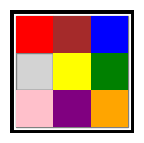

To a state incorporating the following block position(s):


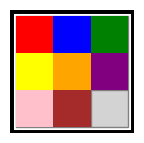

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 9
Goal state is:


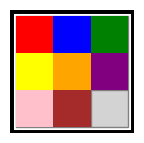

The action path to the solution is:
('yellow', 'left')
('brown', 'down')
('blue', 'left')
('green', 'up')
('orange', 'up')
('purple', 'right')
('brown', 'down')
('orange', 'left')
('purple', 'up')


SEARCH SPACE STATS:
Total nodes generated          =     1167  (includes start)
Nodes discarded by loop_check  =      476  (691 distinct states added to queue)
Nodes tested (by goal_test)    =      434  (433 expanded + 1 goal)
Nodes left in queue            =      257

Time taken = 0.0881 seconds

Solve the following sliding blocks problem.
Get from this initial state:


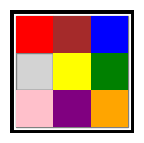

To a state incorporating the following block position(s):


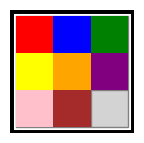

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 9
Goal state is:


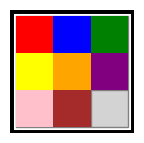

The action path to the solution is:
('yellow', 'left')
('brown', 'down')
('blue', 'left')
('green', 'up')
('orange', 'up')
('purple', 'right')
('brown', 'down')
('orange', 'left')
('purple', 'up')


SEARCH SPACE STATS:
Total nodes generated          =      484  (includes start)
Nodes discarded by loop_check  =      191  (293 distinct states added to queue)
Nodes tested (by goal_test)    =      174  (173 expanded + 1 goal)
Nodes left in queue            =      119

Time taken = 0.0542 seconds

Solve the following sliding blocks problem.
Get from this initial state:


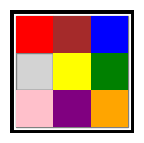

To a state incorporating the following block position(s):


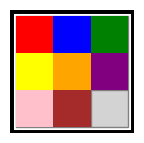

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 9
Goal state is:


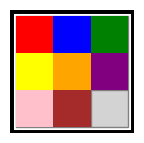

Cost of reaching goal: 9
The action path to the solution is:
('yellow', 'left')
('brown', 'down')
('blue', 'left')
('green', 'up')
('orange', 'up')
('purple', 'right')
('brown', 'down')
('orange', 'left')
('purple', 'up')


SEARCH SPACE STATS:
Total nodes generated          =      833  (includes start)
Nodes discarded by loop_check  =      331  (502 distinct states added to queue)
Nodes tested (by goal_test)    =      303  (302 expanded + 1 goal)
Nodes left in queue            =      199

Time taken = 0.0626 seconds

Solve the following sliding blocks problem.
Get from this initial state:


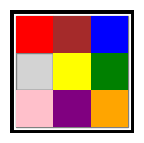

To a state incorporating the following block position(s):


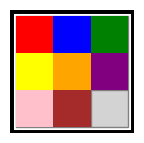

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 9
Goal state is:


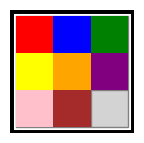

The action path to the solution is:
('yellow', 'left')
('brown', 'down')
('blue', 'left')
('green', 'up')
('orange', 'up')
('purple', 'right')
('brown', 'down')
('orange', 'left')
('purple', 'up')


SEARCH SPACE STATS:
Total nodes generated          =      484  (includes start)
Nodes discarded by loop_check  =      191  (293 distinct states added to queue)
Nodes tested (by goal_test)    =      174  (173 expanded + 1 goal)
Nodes left in queue            =      119

Time taken = 0.0591 seconds

Solve the following sliding blocks problem.
Get from this initial state:


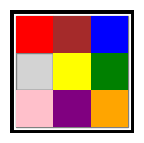

To a state incorporating the following block position(s):


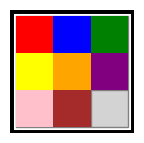

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 9
Goal state is:


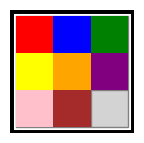

Cost of reaching goal: 9
The action path to the solution is:
('yellow', 'left')
('brown', 'down')
('blue', 'left')
('green', 'up')
('orange', 'up')
('purple', 'right')
('brown', 'down')
('orange', 'left')
('purple', 'up')


SEARCH SPACE STATS:
Total nodes generated          =      833  (includes start)
Nodes discarded by loop_check  =      331  (502 distinct states added to queue)
Nodes tested (by goal_test)    =      303  (302 expanded + 1 goal)
Nodes left in queue            =      199

Time taken = 0.0778 seconds

Solve the following sliding blocks problem.
Get from this initial state:


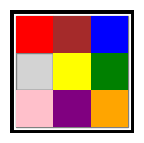

To a state incorporating the following block position(s):


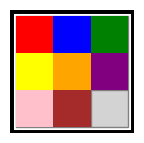

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
......
:-)) *SUCCESS* ((-:

Path length = 6573
Goal state is:


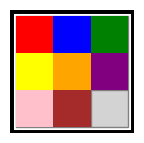

The action path to the solution is:
('pink', 'up')
('purple', 'left')
('orange', 'left')
('green', 'down')
('yellow', 'right')
('brown', 'down')
('blue', 'left')
('yellow', 'up')
('brown', 'right')
('pink', 'right')
('purple', 'up')
('orange', 'left')
('pink', 'down')
('brown', 'left')
('yellow', 'down')
('blue', 'right')
('brown', 'up')
('pink', 'up')
('green', 'left')
('yellow', 'down')
('pink', 'right')
('brown', 'down')
('blue', 'left')
('pink', 'up')
('brown', 'right')
('purple', 'right')
('orange', 'up')
('green', 'left')
('purple', 'down')
('brown', 'left')
('pink', 'down')
('blue', 'right')
('brown', 'up')
('pink', 'left')
('yellow', 'up')
('purple', 'right')
('pink', 'down')
('brown', 'down')
('blue', 'left')
('yellow', 'up')
('brown', 'right')
('pink', 'up')
('purple', 'left')
('brown', 'down')
('pink', 'right')
('purple', 'up')
('brown', 'left')
('pink', 'down')
('purple', 'right')
('brown', 'up')
('green', 'right')
('orange', 'down')
('brown', 'left')
('purple', 'left')
('p

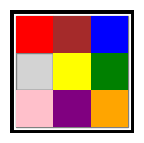

To a state incorporating the following block position(s):


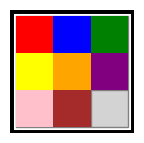

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.
:-)) *SUCCESS* ((-:

Path length = 1785
Goal state is:


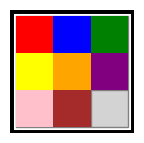

The action path to the solution is:
('pink', 'up')
('purple', 'left')
('orange', 'left')
('green', 'down')
('yellow', 'right')
('brown', 'down')
('blue', 'left')
('yellow', 'up')
('brown', 'right')
('pink', 'right')
('purple', 'up')
('orange', 'left')
('pink', 'down')
('brown', 'left')
('yellow', 'down')
('blue', 'right')
('brown', 'up')
('pink', 'up')
('green', 'left')
('yellow', 'down')
('pink', 'right')
('brown', 'down')
('blue', 'left')
('pink', 'up')
('brown', 'right')
('purple', 'right')
('orange', 'up')
('green', 'left')
('purple', 'down')
('brown', 'left')
('pink', 'down')
('blue', 'right')
('brown', 'up')
('pink', 'left')
('yellow', 'up')
('purple', 'right')
('pink', 'down')
('brown', 'down')
('blue', 'left')
('yellow', 'up')
('brown', 'right')
('pink', 'up')
('purple', 'left')
('brown', 'down')
('pink', 'right')
('purple', 'up')
('brown', 'left')
('pink', 'down')
('purple', 'right')
('brown', 'up')
('green', 'right')
('orange', 'down')
('brown', 'left')
('purple', 'left')
('p

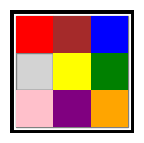

To a state incorporating the following block position(s):


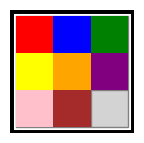

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 9
Goal state is:


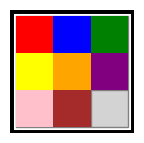

Cost of reaching goal: 9
The action path to the solution is:
('yellow', 'left')
('brown', 'down')
('blue', 'left')
('green', 'up')
('orange', 'up')
('purple', 'right')
('brown', 'down')
('orange', 'left')
('purple', 'up')


SEARCH SPACE STATS:
Total nodes generated          =      897  (includes start)
Nodes discarded by loop_check  =      360  (537 distinct states added to queue)
Nodes tested (by goal_test)    =      328  (327 expanded + 1 goal)
Nodes left in queue            =      209

Time taken = 0.0834 seconds

Solve the following sliding blocks problem.
Get from this initial state:


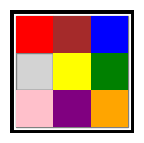

To a state incorporating the following block position(s):


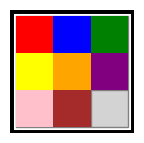

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.
:-)) *SUCCESS* ((-:

Path length = 1785
Goal state is:


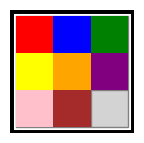

The action path to the solution is:
('pink', 'up')
('purple', 'left')
('orange', 'left')
('green', 'down')
('yellow', 'right')
('brown', 'down')
('blue', 'left')
('yellow', 'up')
('brown', 'right')
('pink', 'right')
('purple', 'up')
('orange', 'left')
('pink', 'down')
('brown', 'left')
('yellow', 'down')
('blue', 'right')
('brown', 'up')
('pink', 'up')
('green', 'left')
('yellow', 'down')
('pink', 'right')
('brown', 'down')
('blue', 'left')
('pink', 'up')
('brown', 'right')
('purple', 'right')
('orange', 'up')
('green', 'left')
('purple', 'down')
('brown', 'left')
('pink', 'down')
('blue', 'right')
('brown', 'up')
('pink', 'left')
('yellow', 'up')
('purple', 'right')
('pink', 'down')
('brown', 'down')
('blue', 'left')
('yellow', 'up')
('brown', 'right')
('pink', 'up')
('purple', 'left')
('brown', 'down')
('pink', 'right')
('purple', 'up')
('brown', 'left')
('pink', 'down')
('purple', 'right')
('brown', 'up')
('green', 'right')
('orange', 'down')
('brown', 'left')
('purple', 'left')
('p

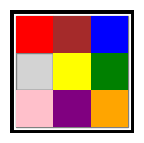

To a state incorporating the following block position(s):


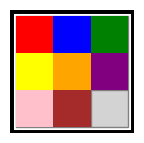

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=COST_1, heuristic=HEURISTIC_2
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 9
Goal state is:


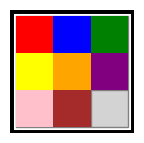

Cost of reaching goal: 9
The action path to the solution is:
('yellow', 'left')
('brown', 'down')
('blue', 'left')
('green', 'up')
('orange', 'up')
('purple', 'right')
('brown', 'down')
('orange', 'left')
('purple', 'up')


SEARCH SPACE STATS:
Total nodes generated          =      897  (includes start)
Nodes discarded by loop_check  =      360  (537 distinct states added to queue)
Nodes tested (by goal_test)    =      328  (327 expanded + 1 goal)
Nodes left in queue            =      209

Time taken = 0.0744 seconds



In [74]:
GOAL_STATE = EIGHT_PUZZLE_G

EIGHT_PUZZLE_RESULTS: dict[str, dict] = {}

# BF Tests
EIGHT_PUZZLE_RESULTS["BF_LC"] = search(EIGHT_PUZZLE, 'BF/FIFO', 100000, return_info=True, loop_check=True)

EIGHT_PUZZLE_RESULTS["BF_LC_HEU1"] = search(EIGHT_PUZZLE, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
EIGHT_PUZZLE_RESULTS["BF_LC_HEU1+COS1"] = search(EIGHT_PUZZLE, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

EIGHT_PUZZLE_RESULTS["BF_LC_HEU2"] = search(EIGHT_PUZZLE, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
EIGHT_PUZZLE_RESULTS["BF_LC_HEU2+COS1"] = search(EIGHT_PUZZLE, 'BF/FIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

# DF Tests
EIGHT_PUZZLE_RESULTS["DF_LC"] = search(EIGHT_PUZZLE, 'DF/LIFO', 100000, return_info=True, loop_check=True)

EIGHT_PUZZLE_RESULTS["DF_LC_HEU1"] = search(EIGHT_PUZZLE, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
EIGHT_PUZZLE_RESULTS["DF_LC_HEU1+COS1"] = search(EIGHT_PUZZLE, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

EIGHT_PUZZLE_RESULTS["DF_LC_HEU2"] = search(EIGHT_PUZZLE, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2)
EIGHT_PUZZLE_RESULTS["DF_LC_HEU2+COS1"] = search(EIGHT_PUZZLE, 'DF/LIFO', 100000, return_info=True, loop_check=True, heuristic=HEURISTIC_2, cost=COST_1)

In [70]:
import pandas as pd

# Flatten the nested dictionaries into a DataFrame


def flatten_results(results):
    rows = []

    for test_name, data in results.items():
        row = {"test_name": test_name}

        # Flatten args
        row.update(data.get("args", {}))

        # Flatten result
        result = data.get("result", {})
        row.update({
            "termination_condition": result.get("termination_condition"),
            "goal_state": result.get("goal_state"),
            "path_length": result.get("path_length")
        })

        # Flatten search stats
        stats = data.get("search_stats", {})
        row.update({
            "nodes_generated": stats.get("nodes_generated"),
            "nodes_tested": stats.get("nodes_tested"),
            "nodes_discarded": stats.get("nodes_discarded"),
            "distinct_states_seen": stats.get("distinct_states_seen"),
            "nodes_left_in_queue": stats.get("nodes_left_in_queue"),
            "time_taken": stats.get("time_taken")
        })

        rows.append(row)

    return pd.DataFrame(rows)

In [75]:
df = flatten_results(EIGHT_PUZZLE_RESULTS)
df[["test_name","path_length", "nodes_generated","nodes_tested","nodes_discarded","time_taken"]]

,test_name,path_length,nodes_generated,nodes_tested,nodes_discarded,time_taken
0,BF_LC,9,1167,434,476,0.088062
1,BF_LC_HEU1,9,484,174,191,0.054246
2,BF_LC_HEU1+COS1,9,833,303,331,0.062556
3,BF_LC_HEU2,9,484,174,191,0.059127
4,BF_LC_HEU2+COS1,9,833,303,331,0.077814
5,DF_LC,6573,19770,6740,7182,1.471457
6,DF_LC_HEU1,1785,5608,1921,2046,1.874459
7,DF_LC_HEU1+COS1,9,897,328,360,0.083421
8,DF_LC_HEU2,1785,5608,1921,2046,0.318420
9,DF_LC_HEU2+COS1,9,897,328,360,0.074422
